# **ML/DL (2주차 1교시)**

## Q1. 이론문제(서술형)

과거에는 시그모이드(Sigmoid) 함수를 주로 사용했으나, 최근 딥러닝(Deep Learning) 모델에서는 은닉층의 활성화 함수로 주로 ReLU를 사용합니다. 층이 깊은 모델에서 시그모이드를 사용할 때 발생하는 '기울기 소실(Vanishing Gradient)' 문제란 무엇이며, ReLU가 이를 어떻게 해결하는지 서술해주세요.

[답변 작성란]

1. 기울기 소실(Vanishing Gradient) 문제란?

기울기 소실 문제란, 깊은 신경망에서 역전파 과정 중 기울기가 점점 작아져 앞쪽 층까지 제대로 전달되지 않는 현상을 의미한다. 과거에 은닉층 활성화 함수로 많이 사용되던 시그모이드(Sigmoid) 함수는 출력값을 0과 1 사이로 제한하며, 그 도함수 값이 최대 0.25에 불과한다. 딥러닝 모델이 깊어질수록 역전파 시 각 층의 도함수 값이 연쇄적으로 곱해지게 되는데, 이때 1보다 작은 값들이 계속 곱해지면 기울기가 지수적으로 감소하게 된다. 특히 시그모이드는 입력값이 매우 크거나 매우 작을 때 포화 영역에 들어가 도함수가 거의 0에 가까워지므로, 앞단의 층으로 갈수록 기울기가 거의 사라지게 된다. 그 결과 초기 층의 가중치는 거의 업데이트되지 않으며, 학습이 매우 느려지거나 사실상 멈추는 문제가 발생한다.

2. ReLU의 해결 방식

ReLU(Rectified Linear Unit)는 입력값이 0보다 크면 그대로 출력하고, 0 이하이면 0을 출력하는 단순한 선형 함수이다. 이 함수는 양수 구간에서 도함수 값이 1이므로, 역전파 과정에서 기울기가 거의 줄어들지 않고 그대로 전달된다. 따라서 여러 층을 거치더라도 기울기가 급격히 감소하지 않아 깊은 신경망에서도 안정적인 학습이 가능하다. 또한 ReLU는 시그모이드와 달리 양수 영역에서 포화되지 않기 때문에 기울기 소실 문제가 크게 완화된다. 이러한 특성 덕분에 최근의 딥러닝 모델에서는 은닉층 활성화 함수로 ReLU가 주로 사용되고 있다.

## Q2. 개념 구현

MNIST 손글씨 분류기 만들기 & 최적화 기법 비교

### 0. 환경 설정 및 데이터 로드

실습에 필요한 라이브러리를 불러오고, MNIST 데이터셋을 다운로드합니다.

이 셀은 수정하지 말고 그대로 실행해주세요.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# 1. 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 적용
set_seed(42)

# 2. 데이터셋 로드 (MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 훈련 데이터
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 테스트 데이터
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 데이터 확인
print(f"Train Data Size: {len(trainset)}")
print(f"Test Data Size: {len(testset)}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 158kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.07MB/s]

Train Data Size: 60000
Test Data Size: 10000


### [문제 1] CNN 모델 구조 설계 (빈칸 채우기)

강의에서 배운 CNN 구조를 조금 더 깊게 만들어 봅니다.

2단 레이어(Conv-Pool-Conv-Pool) 구조를 직접 설계해 주세요.

[구현 조건]

1. Layer 1: Conv(1 $\to$ 32ch) $\to$ ReLU $\to$ MaxPool

2. Layer 2: Conv(32 $\to$ 64ch) $\to$ ReLU $\to$ MaxPool

3. FC Layer: Flatten 후 10개의 클래스로 분류

[힌트: 차원 계산]

- 입력: `28x28`

- Layer 1 통과 후 (Pool): `14x14`

- Layer 2 통과 후 (Pool): `7x7`

In [3]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()

        # ==========================================
        # [TODO 1] 2단 레이어 구조 완성하기
        # ==========================================

        # Layer 1: 입력 1채널 -> 출력 32채널
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Layer 2: 입력 32채널 -> 출력 64채널
        self.layer2 = nn.Sequential(
            # 힌트: Conv2d(in, out, kernel, padding=1)
            # 힌트: MaxPool2d(kernel)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # FC Layer
        # 최종 Feature Map 크기 계산: 28 -> 14 -> 7
        # 따라서 64채널 * 7 * 7 크기가 됨
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)

        # Flatten (1차원으로 펼치기)
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        return x

# 모델 생성 및 구조 확인
model = DeepCNN()
print(model)

DeepCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)


### [문제 2] 학습 루프(Training Loop) 완성하기

딥러닝 모델 학습의 핵심인 경사하강법(Gradient Descent) 3단계를 코드로 구현해 주시면 됩니다.

- Step 1: 기울기 초기화 (`zero_grad`)

- Step 2: 역전파를 통한 기울기 계산 (`backward`)

- Step 3: 가중치 업데이트 (`step`)

In [4]:
def train_model(model, optimizer, criterion, epochs=3, model_name="Model"):
    loss_history = []
    model.train() # 학습 모드 전환

    print(f"=== {model_name} Training Start ===")

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:

            # ==========================================
            # [TODO 2] 경사하강법 3단계 구현하기
            # ==========================================

            # 1. 이전 배치의 기울기 초기화
            optimizer.zero_grad()

            # 순전파 (Forward) 및 Loss 계산
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 2. 역전파 (Backward) - 기울기 계산
            loss.backward()

            # 3. 파라미터 업데이트 (Step)
            optimizer.step()

            running_loss += loss.item()

        # 에포크별 평균 Loss 저장
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}")

    return loss_history

### [문제 3] Optimization 비교: SGD vs Adam

위에서 만든 `train_model` 함수를 사용하여 SGD와 Adam Optimizer의 성능을 비교해 봅니다.

- 실험 A: SGD (Learning Rate = 0.01)

- 실험 B: Adam (Learning Rate = 0.001)

=== SGD Training Start ===
Epoch [1/3] Loss: 0.5858
Epoch [2/3] Loss: 0.1867
Epoch [3/3] Loss: 0.1325
=== Adam Training Start ===
Epoch [1/3] Loss: 0.1637
Epoch [2/3] Loss: 0.0497
Epoch [3/3] Loss: 0.0358


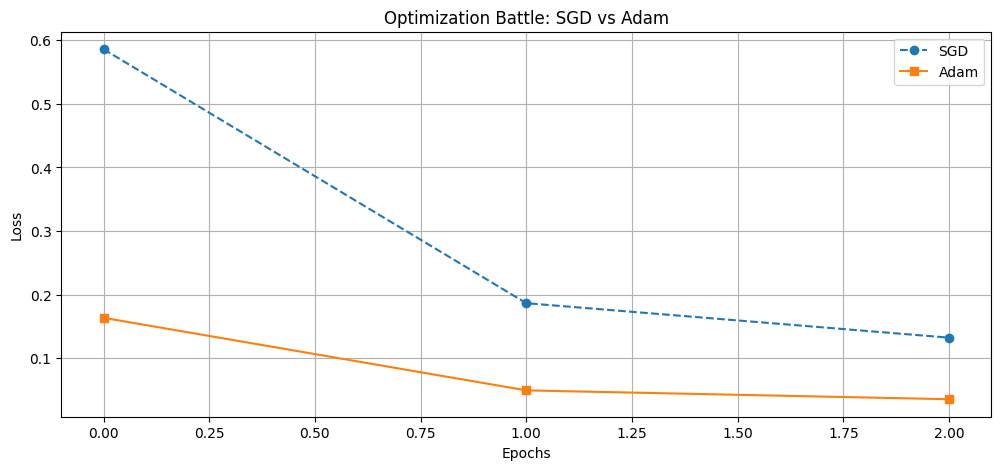

In [5]:
# 공통 손실 함수
criterion = nn.CrossEntropyLoss()

# -------------------------------------------------
# CASE A: SGD Optimizer
# -------------------------------------------------
set_seed(42) # 시드 초기화 (공정한 비교 위해)
model_sgd = DeepCNN()

# [TODO 3-1] SGD Optimizer 설정 (lr=0.01)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

sgd_losses = train_model(model_sgd, optimizer_sgd, criterion, epochs=3, model_name="SGD")

# -------------------------------------------------
# CASE B: Adam Optimizer
# -------------------------------------------------
set_seed(42) # 시드 초기화
model_adam = DeepCNN()

# [TODO 3-2] Adam Optimizer 설정 (lr=0.001)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

adam_losses = train_model(model_adam, optimizer_adam, criterion, epochs=3, model_name="Adam")


# -------------------------------------------------
# 결과 시각화
# -------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(sgd_losses, label='SGD', marker='o', linestyle='--')
plt.plot(adam_losses, label='Adam', marker='s')
plt.title('Optimization Battle: SGD vs Adam')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Q. 그래프를 보고 알 수 있는 점에 대해 작성해주세요.

- SGD: 그래프를 보면 SGD는 에포크가 증가함에 따라 Loss가 꾸준히 감소하는 것을 확인할 수 있다.
1 epoch에서 약 0.59로 시작하여 3 epoch에서는 약 0.13까지 감소하였으며, 학습이 안정적으로 진행되고 있음을 보여준다. 다만 초기 수렴 속도는 비교적 느린 편으로, 첫 번째 에포크에서의 Loss 값이 Adam보다 훨씬 높다. 즉, SGD는 점진적으로 성능이 개선되지만 초반 학습 속도는 상대적으로 느리다는 특징을 보인다.

- Adam: Adam은 첫 에포크부터 약 0.16 수준으로 매우 낮은 Loss를 보이며 빠르게 수렴하는 모습을 나타낸다. 이후에도 Loss가 급격히 감소하여 3 epoch에서 약 0.036까지 도달하였고, SGD보다 전 구간에서 더 낮은 Loss 값을 유지하고 있다. 이는 Adam이 모멘텀과 적응적 학습률(Adaptive Learning Rate)을 활용하여 각 파라미터를 효율적으로 업데이트하기 때문이다. 따라서 Adam은 초기 학습 속도가 빠르고, 짧은 에포크에서도 우수한 성능을 보인다는 점을 그래프를 통해 확인할 수 있다.